In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [2]:
df = pd.read_excel (r'hindi_modelDataset.xlsx', sheet_name='Sheet1')
df.head(20)

,sent_index,word,tag
0,0,जापान,B-LOC
1,0,एशिया,B-LOC
2,0,महाद्वीप,I-LOC
3,0,में,O
4,0,स्थित,O
5,0,देश,O
6,0,है,O
7,0,।,O
8,1,पाकिस्तान,I-LOC
9,1,की,I-ORG


In [3]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["word"].values.tolist(),
                                                        s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sent_index").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [4]:
getter = SentenceGetter(df)

In [5]:
sentences = getter.sentences

In [6]:
print(sentences[10])

[('हिमाचल', 'B-LOC'), ('प्रदेश', 'I-ORG'), ('उत्तर', 'B-LOC'), ('पश्चिमी', 'B-LOC'), ('भारत', 'B-LOC'), ('में', 'O'), ('स्थित', 'O'), ('एक', 'O'), ('राज्य', 'I-LOC'), ('है', 'O'), ('।', 'O')]


In [7]:
maxlen = max([len(s) for s in sentences])
print ('Maximum sequence length:', maxlen)

Maximum sequence length: 367


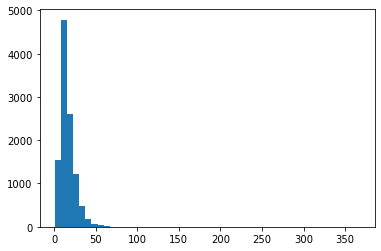

In [8]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [9]:
words = list(set(df["word"].values))
words.append("end_padding")
n_words = len(words)
n_words

17735

In [10]:
tags = list(set(df["tag"].values))
n_tags = len(tags)
n_tags

7

# Feature Generation

In [11]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [12]:
print(type(word2idx))

<class 'dict'>


In [13]:
dict_items = word2idx.items()
first_5 = list(dict_items)[:5]
print(first_5)

[('इगा', 0), ('डगलस', 1), ('दूतावास', 2), ('१२वीं', 3), ('शीतयुद्ध', 4)]


In [14]:

X = [[word2idx[w[0]] for w in s] for s in sentences]

In [15]:
X = pad_sequences(maxlen=150, sequences=X, padding="post",value=n_words - 1)

In [16]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=150, sequences=y, padding="post", value=tag2idx["O"])

In [17]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [19]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

In [20]:
input = Input(shape=(150,))
model = Embedding(input_dim=n_words, output_dim=150, input_length=150)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=150, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)

In [21]:
model = Model(input, out)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [22]:
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=10, validation_split=0.2, verbose=1)

C:\Users\rosha\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 6988 samples, validate on 1747 samples
Epoch 1/10
6988/6988 [==============================] - 234s 33ms/step - loss: 0.1599 - accuracy: 0.9614 - val_loss: 0.0756 - val_accuracy: 0.9766
Epoch 2/10
6988/6988 [==============================] - 238s 34ms/step - loss: 0.0414 - accuracy: 0.9877 - val_loss: 0.0218 - val_accuracy: 0.9948
Epoch 3/10
6988/6988 [==============================] - 236s 34ms/step - loss: 0.0096 - accuracy: 0.9984 - val_loss: 0.0099 - val_accuracy: 0.9980
Epoch 4/10
6988/6988 [==============================] - 240s 34ms/step - loss: 0.0024 - accuracy: 0.9999 - val_loss: 0.0072 - val_accuracy: 0.9981
Epoch 5/10
6988/6988 [==============================] - 217s 31ms/step - loss: 7.7745e-04 - accuracy: 1.0000 - val_loss: 0.0069 - val_accuracy: 0.9981
Epoch 6/10
6988/6988 [==============================] - 236s 34ms/step - loss: 3.5387e-04 - accuracy: 1.0000 - val_loss: 0.0064 - val_accuracy: 0.9982
Epoch 7/10
6988/6988 [==============================] - 239s 3

In [23]:
i = 2
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
print("{:14} ({:5}): {}".format("Word", "True", "Pred"))
for w,pred in zip(X_test[i],p[0]):
    print("{:15}: {}".format(words[w],tags[pred]))

Word           (True ): Pred
भजन            : B-PER
लाल            : B-LOC
तीन            : O
बार            : O
हरियाणा        : B-LOC
के             : I-PER
मुख्यमंत्री    : I-ORG
रहे            : O
।              : O
end_padding    : O
end_padding    : O
end_padding    : O
end_padding    : O
end_padding    : O
end_padding    : O
end_padding    : O
end_padding    : O
end_padding    : O
end_padding    : O
end_padding    : O
end_padding    : O
end_padding    : O
end_padding    : O
end_padding    : O
end_padding    : O
end_padding    : O
end_padding    : O
end_padding    : O
end_padding    : O
end_padding    : O
end_padding    : O
end_padding    : O
end_padding    : O
end_padding    : O
end_padding    : O
end_padding    : O
end_padding    : O
end_padding    : O
end_padding    : O
end_padding    : O
end_padding    : O
end_padding    : O
end_padding    : O
end_padding    : O
end_padding    : O
end_padding    : O
end_padding    : O
end_padding    : O
end_padding    : O
end_padding    : O
e

In [24]:
pred = []
for i in range(len(y_test)):
    p = model.predict(np.array([X_test[i]]))
    p = np.argmax(p, axis=-1)
    pred.append(p)

In [25]:
pred_temp = [x[0] for x in pred]

In [26]:
y_temp = []

In [27]:
for i in range(len(y_test)):
    y_temp.append(np.array([np.where(y_test[i][j]==1)[0][0] for j in range(len(y_test[i]))]))

In [28]:
actual = y_temp[0]
for i in range(1, len(y_temp)):
    actual = np.concatenate((actual, y_temp[i]), axis=None)

In [29]:
predicted = pred_temp[0]
for i in range(1, len(pred_temp)):
    predicted = np.concatenate((predicted, pred_temp[i]), axis=None)

In [30]:
import scikitplot as skplt
from sklearn.metrics import classification_report

              precision    recall  f1-score   support

       B-PER       0.93      0.90      0.92       935
       B-LOC       1.00      0.96      0.98      1857
           O       1.00      1.00      1.00    314472
       I-PER       1.00      0.96      0.98      3266
       I-LOC       1.00      0.98      0.99      1393
       B-ORG       0.99      0.94      0.96      1330
       I-ORG       1.00      0.98      0.99      4347

    accuracy                           1.00    327600
   macro avg       0.99      0.96      0.97    327600
weighted avg       1.00      1.00      1.00    327600



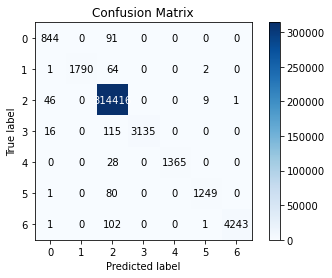

In [31]:
skplt.metrics.plot_confusion_matrix(actual, predicted)
print(classification_report(actual, predicted, target_names=tags))